In [10]:
""""
Figaro times collection times script. 
"""
import numpy as np
import pandas as pd
import os
from openpyxl import load_workbook, Workbook
from openpyxl.utils.cell import get_column_letter

path_src = "/local/scratch/Figaro/figaro-code"
exp_names = ["figaro_mkl", "postprocess_lapack", "mkl"]
exp_paths = {"figaro_mkl": "comparisons/performance/figaro/lapack", 
"figaro_thin_diag": "comparisons/performance/figaro/thin/diag", 
"mkl": "comparisons/performance/python/mkl",
"postprocess_lapack": "comparisons/performance/postprocess/lapack"}
db_names = ["DBRetailer", "DBFavorita", "DBYelp"]

start_per = 10
end_per = 100
per_inc = 10

num_measurement = 5

xlsx_name = "time.xlsx"

df_measurement_exps = {}
for exp_name in exp_names: 
    exp_path = exp_paths[exp_name]
    perf_path = os.path.join(path_src, exp_path)
    df_measurement = pd.DataFrame(columns=db_names)

    for db_name in db_names:
        #gather_times_path = os.path.join(perf_path, db_name + xlsx_name)
        #print(gather_times_path)
        #out_workbook = Workbook()
        #out_workbook.remove(out_workbook.active)
        #out_sheet = out_workbook.create_sheet("Times")

        for db_idx, percent in enumerate(range(start_per, end_per + 1, per_inc)): 
            db_name_per = "{}PK1C{}".format(db_name, percent)
            path_xlsx = os.path.join(perf_path, db_name_per, xlsx_name)
            workbook = load_workbook(filename=path_xlsx, data_only=True)
            sheet = workbook.active
            row_count = sheet.max_row
            col_idx = db_idx + 1
            col_letter = get_column_letter(col_idx)
            
            #out_sheet.cell(row=1, column=col_idx).value = db_name_per
            
            start_row_idx = 2
            np_measures = np.zeros(num_measurement)
            for row_idx_dst in range(start_row_idx, start_row_idx + num_measurement):
                offset_idx = row_idx_dst - start_row_idx
                row_idx_src = row_count - num_measurement  + offset_idx
                val = sheet.cell(row=row_idx_src, column=2).value
                np_measures[offset_idx] = float(val)
                #print(idx_shift, db_idx)
                #out_sheet.cell(row=row_idx_dst, column=col_idx).value = val
            
            #out_sheet.cell(row=start_row_idx + num_measurement, column=col_idx).value = '=AVERAGE({}{}:{}{})'.format(col_letter, start_row_idx + 1, 
            #        col_letter,6)

            time_avg = np.mean(np_measures[1:])
            df_measurement.at[percent, db_name] = time_avg
            
        #out_workbook.save(gather_times_path)
        print(df_measurement)
        df_measurement.index = df_measurement.index.set_names(['index'])
        df_measurement = df_measurement.astype(float)
    df_measurement_exps[exp_name] = df_measurement





    DBRetailer DBFavorita DBYelp
10     2.57352        NaN    NaN
20      5.6161        NaN    NaN
30     8.69558        NaN    NaN
40     12.5505        NaN    NaN
50     15.5196        NaN    NaN
60     19.9528        NaN    NaN
70     24.8362        NaN    NaN
80     29.7045        NaN    NaN
90     33.9374        NaN    NaN
100     41.914        NaN    NaN
       DBRetailer  DBFavorita  DBYelp
index                                
10       2.573522    3.285450     NaN
20       5.616103    7.434119     NaN
30       8.695582   10.926960     NaN
40      12.550513   14.804263     NaN
50      15.519551   19.673223     NaN
60      19.952841   23.986007     NaN
70      24.836169   28.164738     NaN
80      29.704548   33.759966     NaN
90      33.937440   39.283700     NaN
100     41.913997   45.337670     NaN
       DBRetailer  DBFavorita    DBYelp
index                                  
10       2.573522    3.285450  0.152140
20       5.616103    7.434119  0.158364
30       8.695582   1

In [11]:
import csv

db_name_map = {
    "DBFavorita": "exp1perf-favorita.dat", 
    "DBRetailer": "exp1perf-retailer.dat", 
    "DBYelp": "exp1perf-yelp.dat"
    }
exp_dat_names = ["#percentage of data", "figaro-time", "mkl-time"]
"""
for db_name in db_names:
    dbs_results = []
    for exp_name in exp_names:
        dbs_results.append(df_measurement_exps[exp_name][db_name])
    df_db_results = pd.concat(dbs_results, axis=1)
    df_db_results = df_db_results.reset_index().rename(columns={df_db_results.index.name:'index'})
    df_db_results.columns = exp_dat_names
    df_db_results.to_csv(db_name_map[db_name], float_format='%.2f', sep='\t', index=False, quoting=csv.QUOTE_NONE,  escapechar=" ")
"""

'\nfor db_name in db_names:\n    dbs_results = []\n    for exp_name in exp_names:\n        dbs_results.append(df_measurement_exps[exp_name][db_name])\n    df_db_results = pd.concat(dbs_results, axis=1)\n    df_db_results = df_db_results.reset_index().rename(columns={df_db_results.index.name:\'index\'})\n    df_db_results.columns = exp_dat_names\n    df_db_results.to_csv(db_name_map[db_name], float_format=\'%.2f\', sep=\'\t\', index=False, quoting=csv.QUOTE_NONE,  escapechar=" ")\n'

{'figaro_mkl':        DBRetailer  DBFavorita    DBYelp
index                                  
10       2.573522    3.285450  0.152140
20       5.616103    7.434119  0.158364
30       8.695582   10.926960  0.154378
40      12.550513   14.804263  0.159066
50      15.519551   19.673223  0.161596
60      19.952841   23.986007  0.155791
70      24.836169   28.164738  0.172704
80      29.704548   33.759966  0.188683
90      33.937440   39.283700  0.181063
100     41.913997   45.337670  0.177327, 'postprocess_lapack':        DBRetailer  DBFavorita    DBYelp
index                                  
10       2.499777    3.219984  1.004594
20       5.231756    8.190021  1.672908
30       8.521548   10.584761  2.415123
40      11.937216   14.275166  3.519769
50      14.947563   17.761601  4.509230
60      19.532032   22.935316  5.723729
70      22.491848   26.798586  7.733885
80      27.227103   32.556615  8.600114
90      32.923069   36.296452  8.115175
100     37.572898   43.404652  8.945138, '

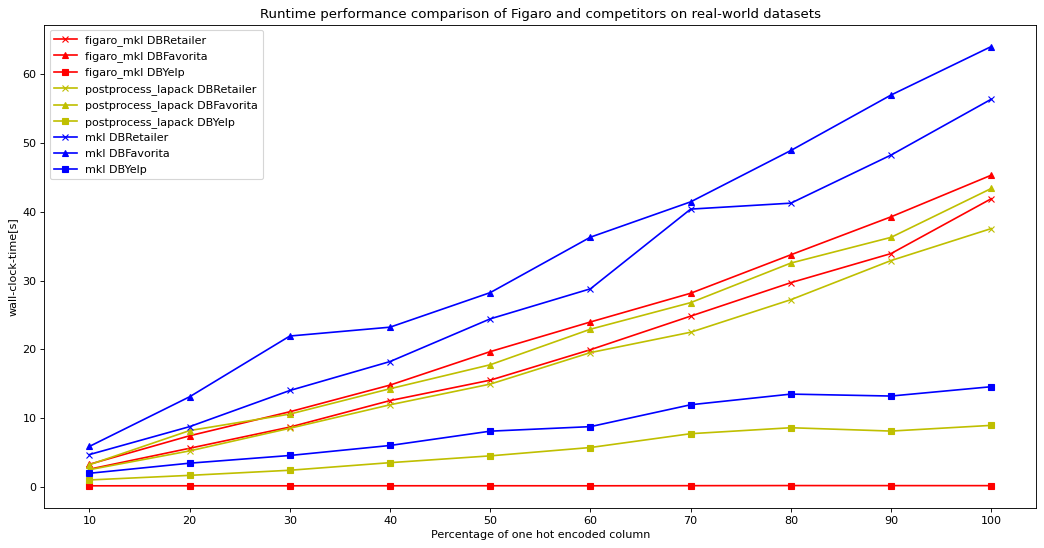

In [12]:
import matplotlib.pyplot as plt

plt.figure("name", figsize=(16, 8), dpi=80)
plt.xlabel("Percentage of one hot encoded column")
plt.ylabel("wall-clock-time[s]")

plt.title("Runtime performance comparison of Figaro and competitors on real-world datasets")

plt.yscale('linear')
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='x', nbins=10)
db_marker =  {"DBFavorita": "^", "DBYelp": "s", "DBRetailer": "x"}
exp_colour = {"figaro_mkl": "r", "figaro_thin_diag": 'g', "mkl": "b", "postprocess_lapack": "y"}

print(df_measurement_exps)
for exp_name in exp_names:
    print(exp_name)
    df_measurement = df_measurement_exps[exp_name]
    for db_name in df_measurement:
        print(df_measurement[db_name])
        plt.plot(df_measurement[db_name], "-" + exp_colour[exp_name] + db_marker[db_name], label="{} {}".format(exp_name, db_name))
plt.legend(loc="upper left")

plt.show()